# Livrable 2 : Traitement d'images
|Erwan Martin|Thibaut Liger-Hellard|Arnaud Maturel|Guillaume Le Cocguen|Victorien Goudeau|
|------------|---------------------|--------------|--------------------|-----------------|

# **Contexte**:
L'entreprise TouNum, spécialisée dans la numérisation de documents, collabore avec des spécialistes en Data Science de CESI pour développer une solution de Machine Learning capable de générer automatiquement des légendes pour les images numérisées. Ce projet vise à enrichir leur offre de services en répondant aux besoins de clients ayant d'importantes quantités de données à classer. Le défi inclut le nettoyage des images de qualité variable et la distinction entre photos et autres types d'images avant l'analyse. L'approche utilisera des technologies avancées telles que les réseaux de neurones convolutifs (CNN) et récurrents (RNN), en s'appuyant sur Python et des librairies spécialisées. Un prototype est attendu dans cinq semaines, suivi d'une présentation détaillée et d'une discussion sur l'intégration et la maintenance de la solution.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import sklearn
import sklearn.model_selection
import tensorflow as tf
import tensorboard
import cv2
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=9144)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [13]:
import os
from sklearn.model_selection import train_test_split

def split_data(image_folder, train_size=0.7, test_size=0.2):
    
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    
    train_files, val_test_files = train_test_split(image_files, train_size=train_size, random_state=42)
    
    val_size = test_size / (1 - train_size)  # Calcul pour garder la proportion correcte pour le test
    val_files, test_files = train_test_split(val_test_files, test_size=val_size, random_state=42)
    
    return train_files, val_files, test_files


filePath = open('../data/path.txt', "r")
datapath = filePath.read()
print(datapath)

image_folder = datapath+'/Photo'
train_files, val_files, test_files = split_data(image_folder)


D:\CESI\A5\datascience\Projet\data


In [14]:
def image_noise_generator(image_files, batch_size, noise_factor=0.5, img_size=(400, 400)):
    while True:
        image_files = shuffle(image_files)
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            batch_images = []
            batch_noisy_images = []
            for file in batch_files:
                img = cv2.imread(file)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = img.astype('float32') / 255.0
                    noisy_img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
                    noisy_img = np.clip(noisy_img, 0, 1)
                    batch_images.append(img)
                    batch_noisy_images.append(noisy_img)
            yield np.array(batch_noisy_images), np.array(batch_images)


In [19]:
def denoises_model():
    inputs = tf.keras.Input(shape=(400, 400, 3))
    x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
    xp1 = tf.keras.layers.MaxPool2D(2,2)(x)
    x1 = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(xp1)
    xp2 = tf.keras.layers.MaxPool2D(2,2)(x1)
    x2 = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(xp2)
    xp3 = tf.keras.layers.MaxPool2D(2,2)(x2)
    x3 = tf.keras.layers.Conv2D(256, 3, activation="relu", strides=1, padding="same")(xp3)
    xp4 = tf.keras.layers.MaxPool2D(2,2)(x3)
    encodeur = tf.keras.Model(inputs, xp4, name="encoded")

    decoder_input = tf.keras.Input(shape=(25, 25, 256))
    z = tf.keras.layers.Conv2DTranspose(64, 5, activation="relu", strides=1, padding="same")(decoder_input)
    zp1 = tf.keras.layers.UpSampling2D((2,2))(z)
    z1 = tf.keras.layers.Conv2DTranspose(32, 5, activation="relu", strides=1, padding="same")(zp1)
    zp2 = tf.keras.layers.UpSampling2D((2,2))(z1)
    z2 = tf.keras.layers.Conv2DTranspose(8, 5, activation="relu", strides=1, padding="same")(zp2)
    zp3 = tf.keras.layers.UpSampling2D((2,2))(z2)
    z3 = tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(zp3)
    outputs = tf.keras.layers.UpSampling2D((2,2))(z3)
    decodeur = tf.keras.Model(decoder_input, outputs, name="decoded")

    auto_input = tf.keras.Input(shape=(400, 400, 3))
    encoded = encodeur(auto_input)
    decoded = decodeur(encoded)
    auto_encodeur = tf.keras.Model(auto_input, decoded, name="auto_encodeur")
    auto_encodeur.compile(optimizer='adam', loss='mean_squared_error')

    return auto_encodeur

auto_encodeur_model = denoises_model()
auto_encodeur_model.summary()


Model: "auto_encodeur"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 400, 400, 3)]     0         
                                                                 
 encoded (Functional)        (None, 25, 25, 256)       388416    
                                                                 
 decoded (Functional)        (None, 400, 400, 3)       467523    
                                                                 
Total params: 855,939
Trainable params: 855,939
Non-trainable params: 0
_________________________________________________________________


In [20]:
batch_size = 32

train_generator = image_noise_generator(train_files, batch_size)
val_generator = image_noise_generator(val_files, batch_size)
test_generator = image_noise_generator(test_files, batch_size)

steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size
test_steps = len(test_files) // batch_size


In [21]:
checkpoint_filepath = '../model/auto.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

In [22]:

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1,
    mode='min',
    restore_best_weights=True)

In [23]:
history = auto_encodeur_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
218/218 [==============================] - 202s 861ms/step - loss: 0.0243 - val_loss: 0.0134
Epoch 2/10
218/218 [==============================] - 175s 765ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 3/10
218/218 [==============================] - 164s 755ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 4/10
218/218 [==============================] - 162s 745ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 5/10
218/218 [==============================] - 209s 962ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 6/10
218/218 [==============================] - 258s 1s/step - loss: 0.0091 - val_loss: 0.0087
Epoch 7/10
218/218 [==============================] - 260s 1s/step - loss: 0.0087 - val_loss: 0.0085
Epoch 8/10
218/218 [==============================] - 260s 1s/step - loss: 0.0085 - val_loss: 0.0086
Epoch 9/10
218/218 [==============================] - 259s 1s/step - loss: 0.0084 - val_loss: 0.0083
Epoch 10/10
218/218 [==============================] - 261s 1s/step - loss: 

In [24]:
test_loss = auto_encodeur_model.evaluate(test_generator, steps=test_steps)
print('Test Loss:', test_loss)

62/62 [==============================] - 73s 1s/step - loss: 0.0079
Test Loss: 0.007941246964037418


In [112]:
import random

def prepare_example(number, folder, model, noise_factor=0.5, img_size = (400,400)):
    image_files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    random.shuffle(image_files)
    image_files = image_files[:number]

    original_images = []
    noised_images = []
    denoised_images = []

    for file in image_files:
        img = cv2.imread(file)
        if img is not None:
            img_correct_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_correct_color, img_size)
            img_normalized = img_resized.astype('float32') / 255.0
            img_batch = np.expand_dims(img_normalized, axis=0)
            noisy_img = img_batch + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img_batch.shape)
            noisy_img = np.clip(noisy_img, 0, 1)


            predicted = model.predict(noisy_img)
            predicted_image = predicted.squeeze()

            # print(f"original : {img_resized.shape}")
            # print(f"noised : {(noisy_img[0,:,:,:]*255).astype('int8')}")

            original_images.append(img_resized)
            noised_images.append(noisy_img[0,:,:,:])
            denoised_images.append(predicted_image)

    return original_images, noised_images, denoised_images

def display_images(original_images, noised_images, denoised_images):
    plt.figure(figsize=(30, 10))
    
    num_images = len(original_images)
    for i in range(num_images):
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")


        ax = plt.subplot(3, num_images, i + 1+ num_images)
        plt.imshow(noised_images[i])
        plt.title("noised")
        plt.axis("off")

        ax = plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(denoised_images[i])
        plt.title("Denoised")
        plt.axis("off")
    
    plt.show()

1/1 [==============================] - 0s 16ms/step


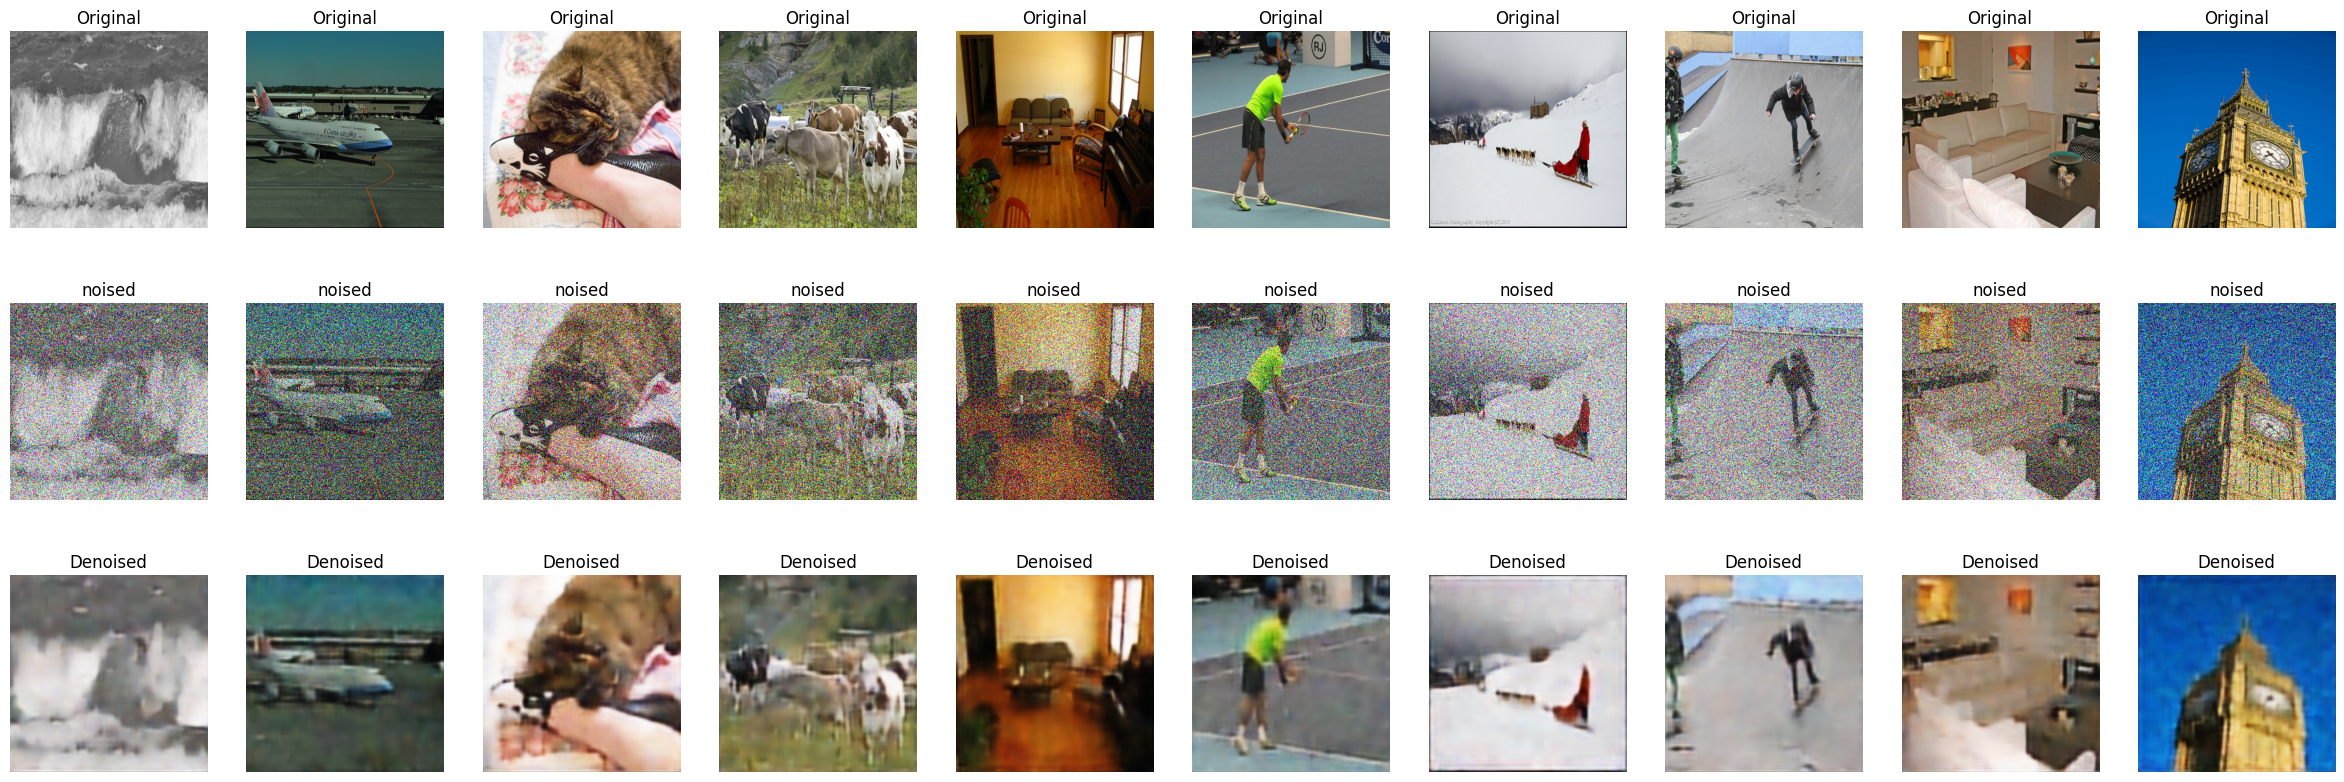

In [119]:
test_image_folder = datapath+'\Dataset_L2'

original_imgs, noised_images, denoised_imgs = prepare_example(10, test_image_folder, auto_encodeur_model, noise_factor=0.5)

display_images(original_imgs, noised_images, denoised_imgs)